In [1]:
from osgeo import gdal
# import input_test
import io
import numpy as np
import tensorflow as tf
import time
import dice
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import distance
%matplotlib inline

/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
c1=128
c2=256
fc=1024
b1=128
b2=256
b3=1024
n_classes = 4
bands = 6

modelo = "/media/gitecx/Nuevo vol/ASIAlac/Modelos/Modelos_TOA/22/33/TOA_33"
mask_tuparro = "/media/gitecx/Nuevo vol/Untitled Folder/000Nueva carpeta2/Final Shape's/Tupa2.shp"
mask_validacion = "/media/gitecx/Nuevo vol/Untitled Folder/000Nueva carpeta2/Final Shape's/Borrar/Validacion_sin_nubes.shp"
mask_rios = "/media/gitecx/Nuevo vol/Untitled Folder/000Nueva carpeta2/Final Shape's/Rios_mask.shp"
mask_validacion2 = "/media/gitecx/Nuevo vol/Untitled Folder/000Nueva carpeta2/Final Shape's/mask_validation_2.shp"

raster_tupa = "/media/gitecx/Gits/Investigacion/TOA/Tuparro/Untitled Folder/Tuparro.tif"
raster_validacion = "/media/gitecx/Gits/Investigacion/TOA/Validacion/Validacion.tif"
raster_rios = "/media/gitecx/Gits/Investigacion/Tuparro7/rios.tif"
raster_validacion2 = "/media/gitecx/Gits/Investigacion/TOA/Validacion_2/Validacion_TOA.tif"
# nor = [[66.0256576538,9.78121852875],
#           [30.048833847,7.67984247208],
#           [29.3293247223,12.6006278992],
#           [54.2133483887,21.600692749],
#           [72.5908813477,35.8457832336],
#           [135.637451172,6.49729347229],
#           [29.8476581573,19.1047420502]]

# nor =[[65.5665740967,7.59398984909 ],
#           [29.6208076477,6.93409013748],
#           [29.2007141113,12.0752677917],
#           [51.8405570984,21.7817344666],
#           [71.6743240356,35.8052330017],
#           [136.855209351,5.64930200577],
#           [30.4583797455,19.0720615387]]

# nor =[[65.6010894775,7.67289638519],
# [29.6660957336,7.03495883942],
# [29.2491416931,12.236114502],
# [51.7747344971,21.8792800903],
# [71.5599060059,36.1383056641],
# [136.822219849,5.64886713028],
# [30.4312267303,19.2929821014]]


nor = [[0.0956493616104,0.0107377385721],
            [0.0848653763533,0.0197297353297],
            [0.0725898742676,0.0294537376612],
            [0.17284463346,0.0683330073953],
            [0.152564808726,0.0728877186775],
            [0.086240015924,0.0554821528494]]

In [3]:
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='VALID'),b))

def max_pool(img):
    return tf.nn.max_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv_net2(images,w,b,_dropout):
    # Conv 1
    conv1 = conv2d(images,w['wc1'], b['bc1'])    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    #Conv 2
    conv2 = conv2d(conv1, w['wc2'], b['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2)
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, w['wd1'].get_shape().as_list()[0]]) 
        
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, w['wd1']),b['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, w['out']),b['out'])
    return out


In [4]:
keep_prob = tf.placeholder(tf.float32) 
# tf Graph input
x = tf.placeholder(tf.float32,[None,20,20,bands])
y = tf.placeholder("float", [None, n_classes])

patch = tf.placeholder("float", [1,20, 20, 6])
    
weights = {  
   # 5x5 conv, 7 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, bands, c1])), 
     # 5x5 conv, 128 inputs, 256 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, c1, c2])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*c2, fc])), 
        # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([fc, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([b1])),
    'bc2': tf.Variable(tf.random_normal([b2])),
    'bd1': tf.Variable(tf.random_normal([b3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }
saver = tf.train.Saver()

pred = conv_net2(x,weights,biases, keep_prob) 

# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [5]:

def raster(r="/media/gitecx/Gits/Investigacion/Tuparro7/tuparro.vrt"):
    ds = gdal.Open(r)
    
    geo=ds.GetGeoTransform()       
    x0=geo[0]
    y0=geo[3]
    pixelwidth=geo[1]
    pixelhigh=abs(geo[5])
    width = ds.RasterXSize
    high = ds.RasterYSize    
    yi=y0-(pixelhigh*high)
    xi=x0+(pixelwidth*width)          
    return [x0,y0,xi,yi]

def maskBinary (array):

    from scipy import ndimage
    valueMin=ndimage.minimum(array)
    valueMax=ndimage.maximum(array)
    if ((valueMin ==0) | (valueMax ==255) | (valueMax ==65535) ):
        return False
    else: return True
    

class Path:
    
    def __init__(self, folder):
        from osgeo import ogr
        self.daShapefile = folder
        # Abrir el Shapefile y tipo de archivo, leer el extent
        self.shape=ogr.GetDriverByName('ESRI Shapefile')
        self.dataSource = self.shape.Open(self.daShapefile)
        self.layer = self.dataSource.GetLayer()
        self.xmin, self.xmax, self.ymin, self.ymax = self.layer.GetExtent()
        
    
    def mean_(self,array):
        if(array.mean()>0):
            return True
        else:
            return False
        
    def extractMatrix (self, pixel_size, pace, overlap, overSampling,ctr=True):
        
        from  scipy import ndimage
        from scipy.ndimage import label
        overLap=0
        avr=80

        if(overlap > 0):
            if(overlap <= 90):
                overLap=(overlap*pace)/100
        # tamaño de los pixeles y valores sin dato

        pixel_size = 30
        NoData_value = 255 
        
        # crear data source de salida
        x_res = int((self.xmax - self.xmin) / pixel_size)
        y_res = int((self.ymax - self.ymin) / pixel_size)

        dataSource = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
        dataSource.SetGeoTransform((self.xmin, pixel_size, 0, self.ymax, 0, -pixel_size))
        band = dataSource.GetRasterBand(1)
        band.SetNoDataValue(NoData_value)
        # rasterizar
        gdal.RasterizeLayer(dataSource, [1], self.layer, burn_values=[1])        
        # leer como array
        geo = dataSource.GetGeoTransform()  
        array = band.ReadAsArray()
        arraylist=[]  
        step=int(pace)    
        labeled_array, num_features = label(array)
        count=ndimage.find_objects(labeled_array)
        if ctr==True:
            for tuples in count:   
                for l in xrange(tuples[0].start,tuples[0].stop,int(step-overLap)):
                    for s in xrange(tuples[1].start,tuples[1].stop,step-overLap):
                        if(overSampling==False):                    
                            A=array[l:l+step, s:s+step]  
                            xmin=(s*pixel_size)+geo[0]
                            ymax=geo[3]-(pixel_size*l)
                            f=self.mean_(A)
                            if (f==True):
                                arraylist.append([xmin,ymax])
                        
        return arraylist,array
 
   


def flight_signature(signature,shape,raster_):

    colors = [(1,1,1),(0, 0.5, 1), (0.48, 1, 0.47), (1, 0.58, 0),(0.49,0,0)]  # R -> G -> B
    n_bins = [3, 5, 10, 100]  # Discretizes the interpolation into bins
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=5)
    
    signatures = np.load(signature)

    print "Firmas espectrales cargadas correctamente"

    a = Path(shape)
    position, array = a.extractMatrix(30,20,0, overSampling=True) 
    predictions = []
    solo_labels = []
    rlimit = raster(r=raster_)  
    
    x_res = int((a.xmax - a.xmin) / 30)
    y_res = int((a.ymax - a.ymin) / 30)
    
    limit = (int((a.xmin - rlimit[0]) / 30))
    limit2 = abs(int((a.ymax - rlimit[1]) / 30))

    ds = gdal.Open(raster_)
    bands=[]
    bands_count= ds.RasterCount
    
    for i in range(bands_count):   
        band = ds.GetRasterBand(i+1)
        ra=band.ReadAsArray(limit,limit2,x_res,y_res)
        ra=ra*array
        bands.append(ra) 
    myarray = np.asarray(bands)  
    
    spectral=signatures.files
    class_= np.zeros([4,bands_count])
    dis_class= np.zeros(4)
    spectral.sort()    
    
    for i in range(4)   :
   
        class_[i]=signatures[spectral[i]][:,0]
        dis_class[i]=distance.euclidean(class_[i],(class_[i]+signatures[spectral[i]][:,1]))
    

    tamao = myarray.shape
    new_map=np.zeros([tamao[1],tamao[2]])
    clases=np.zeros(4)

    for i in range (tamao[1]):
        for l in range(tamao[2]):
        
            clases[0]=distance.euclidean(myarray[:,i,l],class_[0])
            clases[1]=distance.euclidean(myarray[:,i,l],class_[1])   
            clases[2]=distance.euclidean(myarray[:,i,l],class_[2])
            clases[3]=distance.euclidean(myarray[:,i,l],class_[3])
            v=clases.argmin()
            if (clases[v]<=dis_class[v]):
                new_map[i][l]=v+1
#     imgplot = plt.imshow(new_map,cmap=cm)
    c_dice,mask=dice.coefficient(new_map,shape)
    mask.append(new_map)
    #     plt.show()
    print "Coeficientes de Dice para la clase 1 %.3f clase 2 %.3f clase %.3f clase %.3f" % (c_dice[0], c_dice[1], c_dice[2], c_dice[3])   

    fig = plt.figure(figsize=(12,55))
    a=fig.add_subplot(5,1,1)
    imgplot = plt.imshow(mask[0],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 1')
    
    a=fig.add_subplot(5,1,2)
    imgplot = plt.imshow(mask[1],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 2')
    
    a=fig.add_subplot(5,1,3)
    imgplot = plt.imshow(mask[2],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 3')
    
    a=fig.add_subplot(5,1,4)
    imgplot = plt.imshow(mask[3],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 4')
    
    a=fig.add_subplot(5,1,5)
    imgplot = plt.imshow(mask[4],cmap=cm)
    a.set_title('Prediccion')
    plt.tight_layout()
    plt.show()  
                
                
    
##################################################   Interpolacion    ###################################3
    
    
def flight(r,shape,model,overlap):
    
    posiciones=[]
    a = Path(shape)
    
    position, array = a.extractMatrix(30,20,overlap, overSampling=False) 
    predictions = []

    rlimit = raster(r=r)  
    prediction  = tf.argmax(pred,1)
    
    x_res = int((a.xmax - a.xmin) / 30)
    y_res = int((a.ymax - a.ymin) / 30)
    
    limit = (int((a.xmin - rlimit[0]) / 30))
    limit2 = abs(int((a.ymax - rlimit[1]) / 30))

    ds = gdal.Open(r)
    bands=[]
    
    for i in range(ds.RasterCount):   
        
        band = ds.GetRasterBand(i+1)
        ra=band.ReadAsArray(limit,limit2,x_res,y_res)
        bands.append(ra) 
        
    myarray = np.asarray(bands)  
            
    with tf.Session() as sess :
        sess.run(init)
        saver.restore(sess,model)   
        print  ("Modelo restaurado con exito")
        for i in range(len(position)):
            px = position[i][0]
            py = position[i][1]  
            xOffset = int((px - a.xmin) / 30)
            yOffset = int((py - a.ymax) / (-30))
            
            image = np.copy(myarray[:,yOffset:yOffset+20, xOffset:xOffset+20])
            for i in range(ds.RasterCount):
                image[i,:]=((image[i,:]-nor[i][0])/nor[i][1])
            image = np.expand_dims(image, axis=0)
            image = np.transpose(image, (0, 2,3,1 ))  
        
            if (image.shape == (1,20,20,6)):       
                labels =  prediction.eval(feed_dict={x: image, keep_prob: 1.}, session=sess)    
                predictions.append([[px],[py],labels])
        sess.close  
    return predictions,[x_res,y_res,shape,a.xmin,a.ymax],array

    

In [6]:
# ,x_res,y_res,shape,t,y
def interpolation (predictions,extent,array,metodo='linear')   :
#  return predictions,[x_res,y_res,shape,a.xmin,a.ymax],array

    colors = [(1,1,1),(0, 0.5, 1), (0.48, 1, 0.47), (1, 0.58, 0),(0.49,0,0)]  # R -> G -> B
    n_bins = [3, 5, 10, 100]  # Discretizes the interpolation into bins
    cmap_name = 'my_list'
    
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=5)
    
    my_list1 = [i[0][0] for i in predictions]
    my_list2 = [i[1][0] for i in predictions]
    my_list1 = np.asarray(my_list1)
    my_list2 = np.asarray(my_list2)
    
    my_list1 =  ((my_list1 -  extent[3]) / 30)
    my_list2 =  ((my_list2 -  extent[4]) / (-30))
    
    points = np.zeros((len(predictions),2))
    points[:,0] = my_list1.astype(int)
    points[:,1] = my_list2.astype(int)
   
    values = np.asanyarray([i[2][0] for i in predictions]).astype(float)
    values += 1.0

    
    grid_x, grid_y = np.mgrid[0:extent[0]:1, 0:extent[1]:1]  
    grid_z1 = griddata(points, values, (grid_x, grid_y), method=metodo)
    new_map=grid_z1.T*array

    c_dice,mask=dice.coefficient(new_map,extent[2])
    mask.append(new_map)
    #     plt.show()
    print "Coeficientes de Dice para la clase 1 %.3f clase 2 %.3f clase %.3f clase %.3f" % (c_dice[0], c_dice[1], c_dice[2], c_dice[3])   

    fig = plt.figure(figsize=(12,55))
    a=fig.add_subplot(5,1,1)
    imgplot = plt.imshow(mask[0],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 1')
    
    a=fig.add_subplot(5,1,2)
    imgplot = plt.imshow(mask[1],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 2')
    
    a=fig.add_subplot(5,1,3)
    imgplot = plt.imshow(mask[2],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 3')
    
    a=fig.add_subplot(5,1,4)
    imgplot = plt.imshow(mask[3],cmap=plt.cm.Greys_r)
    a.set_title('Mascara 4')
    
    a=fig.add_subplot(5,1,5)
    imgplot = plt.imshow(mask[4],cmap=cm)
    a.set_title('Prediccion')
    plt.tight_layout()
    plt.show()  
    return new_map

# Tuparro al vuelo
Generado con el modelo de la Red neuronal convolucional sobre los datos de entrenado

Modelo restaurado con exito
Coeficientes de Dice para la clase 1 0.561 clase 2 0.864 clase 0.526 clase 0.230


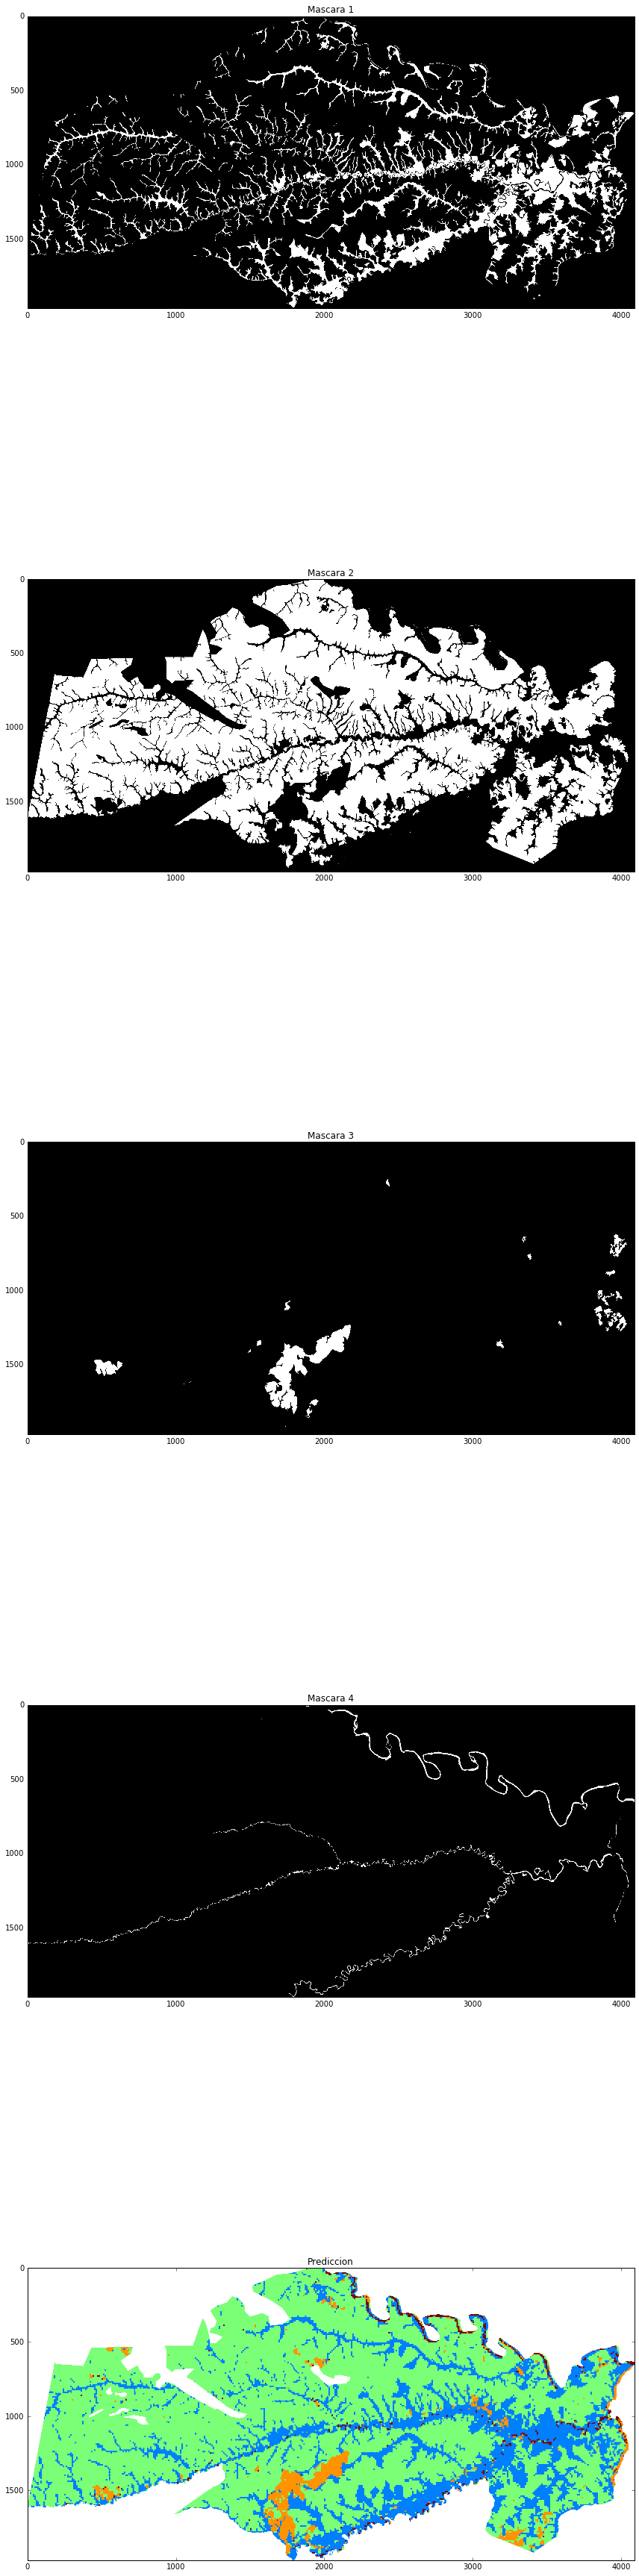

In [7]:
q,w,e = flight(raster_tupa,mask_tuparro,modelo,50)
array=interpolation(q,w,e,metodo='nearest')

# Mapa de validacion al vuelo

Generado con el modelo de la Red neuronal convolucional sobre los datos de validación

Modelo restaurado con exito
Coeficientes de Dice para la clase 1 0.887 clase 2 0.774 clase 0.073 clase 0.107


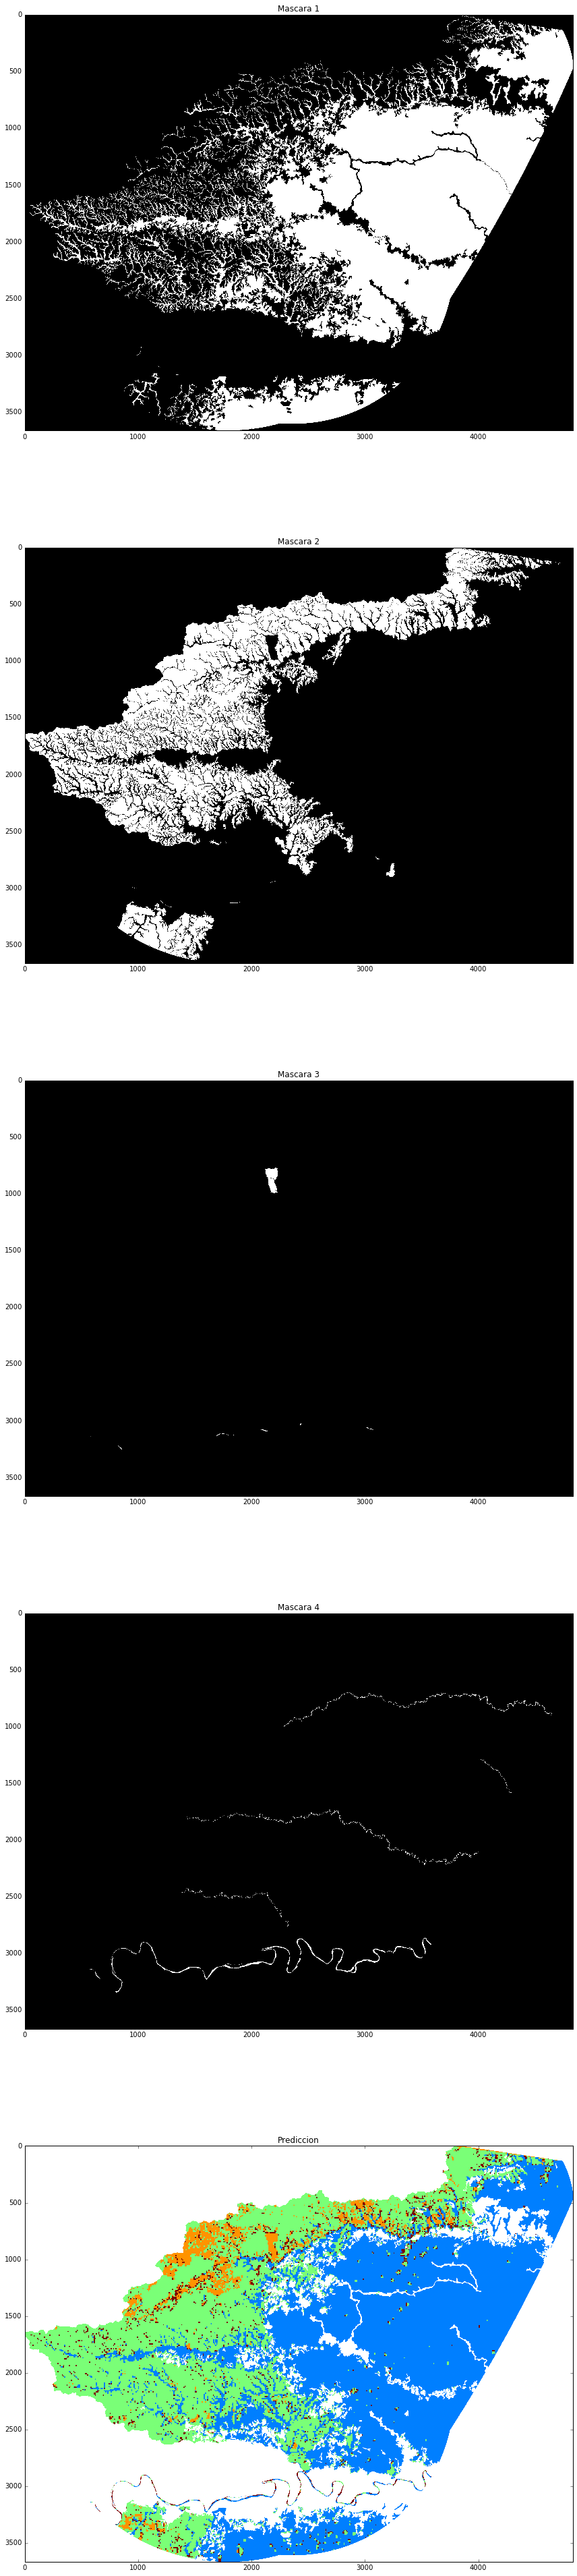

In [8]:
q2,w2,e2 = flight(raster_validacion2,mask_validacion2,modelo,50)
array = interpolation(q2,w2,e2,metodo='nearest')

# Clasificación al vuelo con firmas espectrales

Mapa generado con la clasificación al vuelo utilizando las firmas espectrales de las clases del mapa de entrenamiento y el Algoritmo de distancia minima

Firmas espectrales cargadas correctamente
Coeficientes de Dice para la clase 1 0.576 clase 2 0.819 clase 0.593 clase 0.054


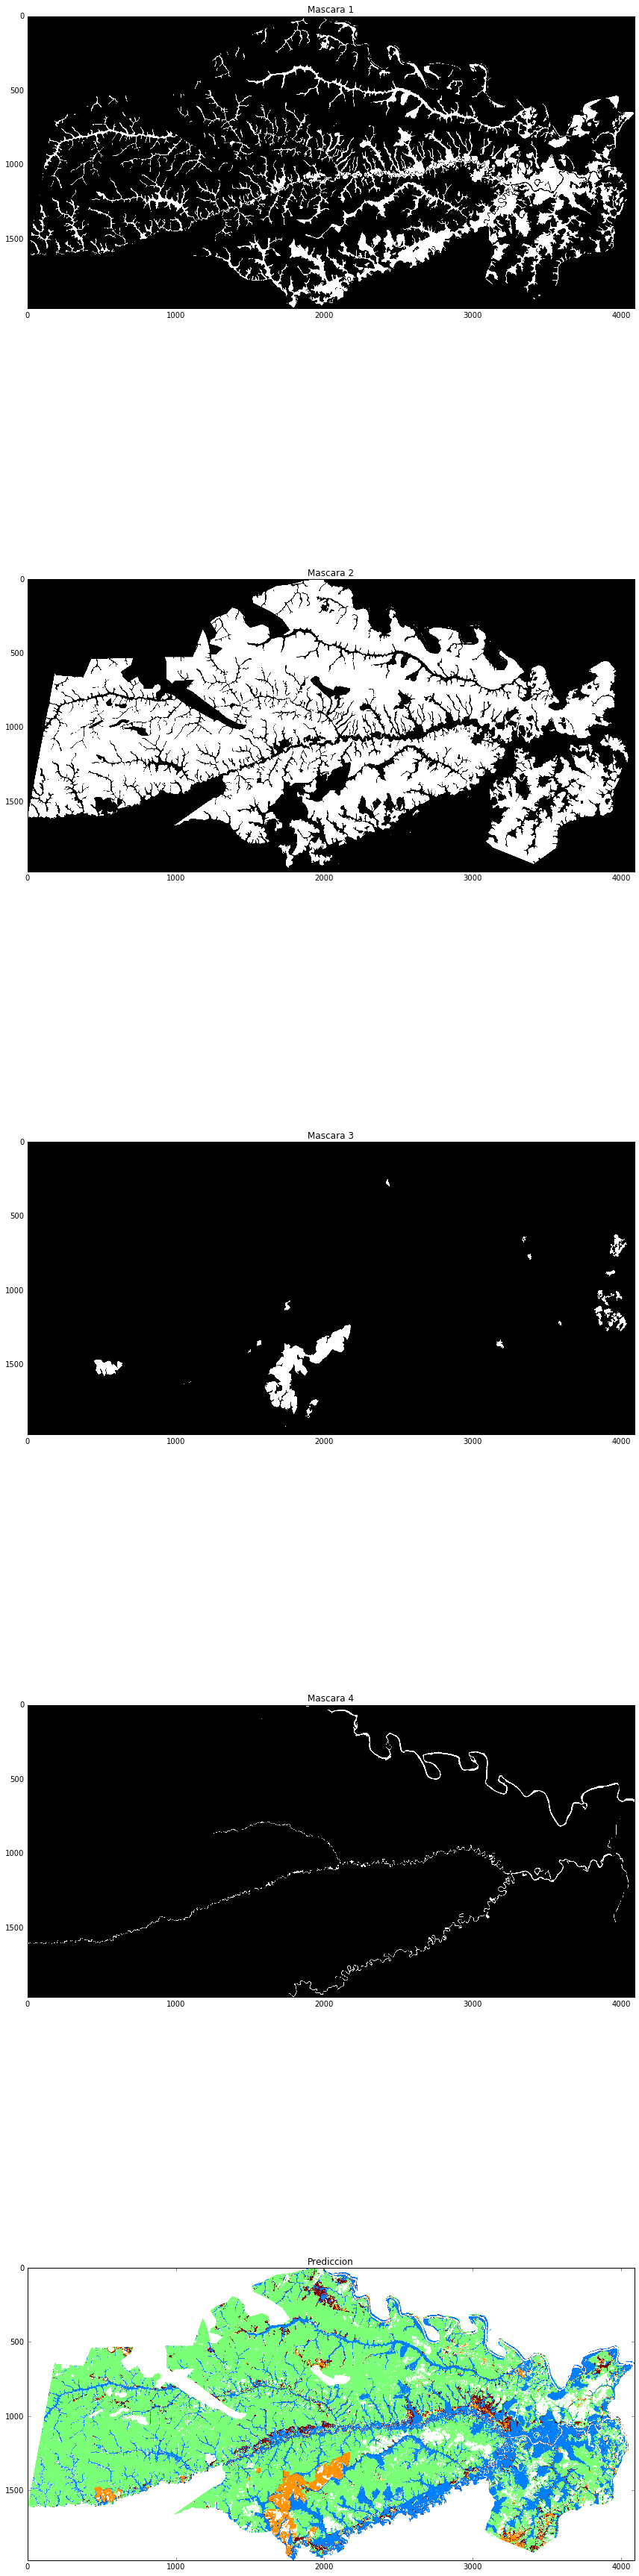

In [8]:

flight_signature("/media/gitecx/Nuevo vol/ASIAlac/asialac/ASIALaC/Spectral Signatures Classes_2.npz",
                 mask_tuparro,raster_tupa)


Firmas espectrales cargadas correctamente
Coeficientes de Dice para la clase 1 0.858 clase 2 0.614 clase 0.122 clase 0.038


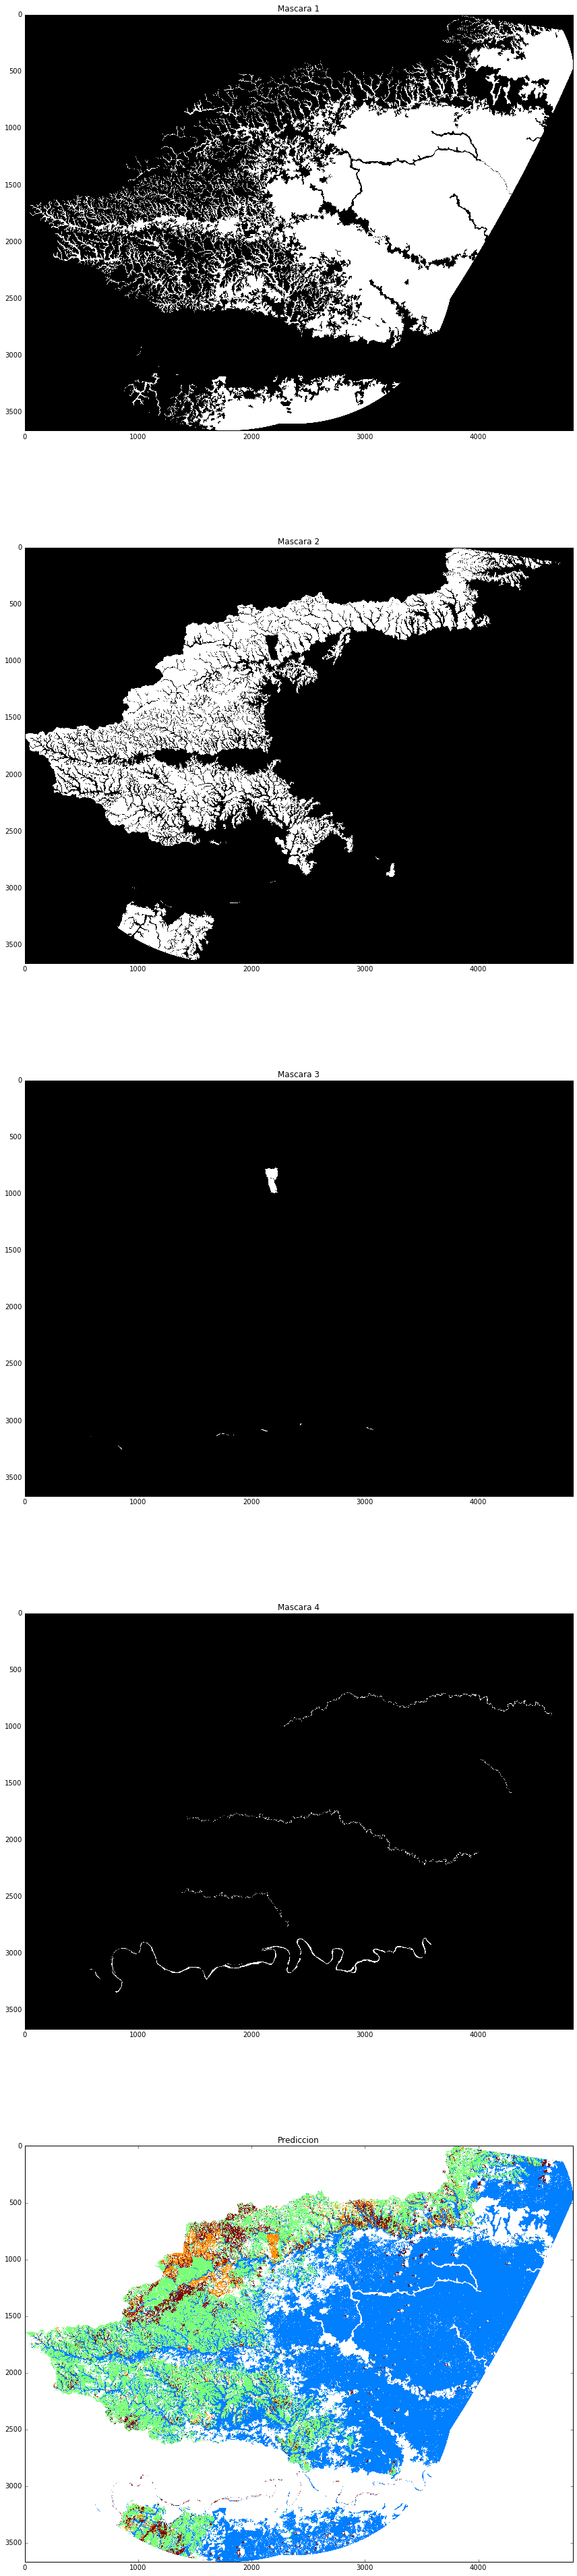

In [9]:
flight_signature("/media/gitecx/Nuevo vol/ASIAlac/asialac/ASIALaC/Spectral Signatures Classes_2.npz",mask_validacion2,raster_validacion2)

